https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt  
https://medium.com/nlplanet/bert-finetuning-with-hugging-face-and-training-visualizations-with-tensorboard-46368a57fc97


In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
from collections import Counter
from multiprocessing import Pool
import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from torchtext.data import get_tokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
# import kaggle

from transformers import BertTokenizer, Trainer, AutoModelForSequenceClassification, AutoTokenizer, BertForSequenceClassification, AdamW, TrainingArguments

import helper_data, helper_model

# nltk.download('stopwords')

c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Steven\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steven\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip install fasttext

## Loading:

In [3]:
# new_directory = "/content/sample_data/"
# os.chdir(new_directory)

In [4]:
RANDOM_STATE = 2023
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
SEQUENCE_LENGTH = 300
CURRENT_DIRECTORY = os.getcwd()
W2V_SIZE = 300
NUM_CORE = multiprocessing.cpu_count()
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10


In [5]:
dataset_filename = {
    '0': ("training.1600000.processed.noemoticon.csv", ["target", "ids", "date", "flag", "user", "text"]),
    '1': ("stock_data.csv", ["text", "target"]),
    '2': ("nasdaq.csv", ["Label", "Ticker", "Headline"]), # 0 negative, 1 positive, 2 neural
    '3': ("djia_news copy.csv", ["Label", "Ticker", "Headline"]), # 0 negative, 1 positive, 2 neural
    '4': ("data-3.csv", ["Sentence", "Sentiment"]),
    '5': ("sentiment.csv", ["Stock Ticker", "Tweet Text", "Sentiment", "Tweet URL"]),
    '6': ('train_tweet.csv', ["id", "label", "tweet"])  # 0 positive, 1 negative
}

In [6]:
dataset_path = os.path.join("", "data", dataset_filename["0"][0])
df0 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["0"][1])
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
df0.target = df0.target.apply(lambda x: decode_map[int(x)])
df0 = df0[['text', 'target']]

dataset_path = os.path.join("", "data", dataset_filename["1"][0])   # test dataset
df1 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["1"][1], skiprows=1)
df1.rename(columns={df1.columns[0]: 'text'}, inplace=True)
decode_map = {-1: "NEGATIVE", 1: "POSITIVE"}
df1.target = df1.target.apply(lambda x: decode_map[int(x)])
df_test = df1

dataset_path = os.path.join("", "data", dataset_filename["2"][0])
df2 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["2"][1], skiprows=1)
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 1: "POSITIVE"}
df2['target'] = df2['Label'].apply(lambda x: decode_map[int(x)])
df2 = df2[['Headline', 'target']]
df2.rename(columns={df2.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["3"][0])
df3 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["3"][1], skiprows=1)
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 1: "POSITIVE"}
df3['target'] = df3['Label'].apply(lambda x: decode_map[int(x)])
df3 = df3[['Headline', 'target']]
df3.rename(columns={df3.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["4"][0])
df4 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["4"][1], skiprows=1)
decode_map = {"negative": "NEGATIVE", "neutral": "NEUTRAL", "positive": "POSITIVE"}
df4['target'] = df4['Sentiment'].apply(lambda x: decode_map[x])
df4.drop(columns=['Sentiment'], inplace=True)
df4.rename(columns={df4.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["5"][0])
df5 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["5"][1], skiprows=1)
decode_map = {"Negative": "NEGATIVE", "Positive": "POSITIVE"}
df5['target'] = df5['Sentiment'].apply(lambda x: decode_map[x])
df5 = df5[['Tweet Text', 'target']]
df5.rename(columns={df5.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["6"][0])
df6 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["6"][1], skiprows=1)
decode_map = {0: "POSITIVE", 1: "NEGATIVE"}
df6['target'] = df6['label'].apply(lambda x: decode_map[int(x)])
df6 = df6[['tweet', 'target']]
df6.rename(columns={df6.columns[0]: 'text'}, inplace=True)

In [7]:
total_rows = len(df0) + len(df2) + len(df3) + len(df4) + len(df5) + len(df6)
print("Total number of rows:", total_rows)

Total number of rows: 1653866


In [8]:
df = pd.concat([df0, df2, df3, df4, df5, df6], ignore_index=True)
df.shape

(1653866, 2)

In [9]:
df = helper_data.shuffle_dataframe(df)

In [10]:
top_10 = df.head(200)
last_10 = df.tail(200) 
df = pd.concat([top_10, last_10])

In [11]:
df = df[df['target'] != "NEUTRAL"]

In [12]:
df[:-10]

,text,target
202341,I just cant have fun anymore,NEGATIVE
1500348,"@GodFirst08 Oh me too, believe me!",POSITIVE
1031598,wassup my fellow twitterers? how's everyone? (...,POSITIVE
22314,got headache,NEGATIVE
1593173,Has juice,POSITIVE
...,...,...
936213,will watch wolverine later. finally. am i late...,POSITIVE
427966,@Rubaa i wish i was so busy as you.....,NEGATIVE
986853,"Eyes wide, Jimmy Eat World just followed me",POSITIVE
697402,"just woke uppp, shitty day outt",NEGATIVE


In [13]:
label_mapping = {'POSITIVE': 0, 'NEGATIVE': 1}
df['target'] = df['target'].map(label_mapping)
df_test['target'] = df_test['target'].map(label_mapping)


target_counts = df['target'].value_counts()
count_df = pd.DataFrame({
    'target': target_counts.index,
    'count': target_counts.values
})
print(count_df)

   target  count
0       1    209
1       0    191


In [14]:
from datasets import Dataset, DatasetDict

df = df.reset_index(drop=True)

train_dataset = Dataset.from_pandas(df)

# Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset
})

In [15]:
from sklearn.model_selection import train_test_split

splitted_datasets = dataset_dict["train"].train_test_split(test_size=0.3)
print(splitted_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'target'],
        num_rows: 280
    })
    test: Dataset({
        features: ['text', 'target'],
        num_rows: 120
    })
})


In [16]:
from datasets import load_dataset, load_metric

metric = load_metric("accuracy")

metric.compute(predictions=[0,0,1,1], references=[0,1,1,1])

C:\Users\Steven\AppData\Local\Temp\ipykernel_10892\295177266.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


{'accuracy': 0.75}

In [17]:
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

tokenizer(["Hello, this one sentence!"])

{'input_ids': [[101, 7592, 1010, 2023, 2028, 6251, 999, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1]]}

In [18]:
def preprocess_function_batch(examples):
    # truncation=True: truncate to the maximum acceptable input length for
    # the model. 
    return tokenizer(examples["text"], truncation=True)

# batched=True: use this if you have a mapped function which can efficiently
# handle batches of inputs like the tokenizer
splitted_datasets_encoded = splitted_datasets.map(preprocess_function_batch, batched=True)
print(splitted_datasets_encoded)

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map: 100%|██████████| 120/120 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 280
    })
    test: Dataset({
        features: ['text', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120
    })
})


In [19]:
# num_labels: number of labels to use in the last layer added to the model,
# typically for a classification task.

# The AutoModelForSequenceClassification class loads the
# DistilBertForSequenceClassification class as underlying model. Since 
# AutoModelForSequenceClassification doesn't accept the parameter 'num_labels', 
# it is passed to the underlying class DistilBertForSequenceClassification, which
# accepts it.

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
task = 1
model_output_dir = f"{model_checkpoint}-finetuned-{task}"
print(model_output_dir) # distilbert-base-uncased-finetuned-imdb
if not os.path.exists(model_output_dir):
    os.makedirs(model_output_dir)

# Start TensorBoard before training to monitor it in progress
%load_ext tensorboard
%tensorboard --logdir '{model_output_dir}'/runs

bert-base-uncased-finetuned-1


Reusing TensorBoard on port 6006 (pid 19308), started 2:42:16 ago. (Use '!kill 19308' to kill it.)

In [21]:
args = TrainingArguments(
    # output_dir: directory where the model checkpoints will be saved.
    output_dir=model_output_dir,
    # evaluation_strategy (default "no"):
    # Possible values are:
    # "no": No evaluation is done during training.
    # "steps": Evaluation is done (and logged) every eval_steps.
    # "epoch": Evaluation is done at the end of each epoch.
    evaluation_strategy="steps",
    # eval_steps: Number of update steps between two evaluations if
    # evaluation_strategy="steps". Will default to the same value as
    # logging_steps if not set.
    eval_steps=50,
    # logging_strategy (default: "steps"): The logging strategy to adopt during
    # training (used to log training loss for example). Possible values are:
    # "no": No logging is done during training.
    # "epoch": Logging is done at the end of each epoch.
    # "steps": Logging is done every logging_steps.
    logging_strategy="steps",
    # logging_steps (default 500): Number of update steps between two logs if
    # logging_strategy="steps".
    logging_steps=50,
    # save_strategy (default "steps"):
    # The checkpoint save strategy to adopt during training. Possible values are:
    # "no": No save is done during training.
    # "epoch": Save is done at the end of each epoch.
    # "steps": Save is done every save_steps (default 500).
    save_strategy="steps",
    # save_steps (default: 500): Number of updates steps before two checkpoint
    # saves if save_strategy="steps".
    save_steps=200,
    # learning_rate (default 5e-5): The initial learning rate for AdamW optimizer.
    # Adam algorithm with weight decay fix as introduced in the paper
    # Decoupled Weight Decay Regularization.
    learning_rate=2e-5,
    # per_device_train_batch_size: The batch size per GPU/TPU core/CPU for training.
    per_device_train_batch_size=16,
    # per_device_eval_batch_size: The batch size per GPU/TPU core/CPU for evaluation.
    per_device_eval_batch_size=16,
    # num_train_epochs (default 3.0): Total number of training epochs to perform
    # (if not an integer, will perform the decimal part percents of the last epoch
    # before stopping training).
    num_train_epochs=1,
    # load_best_model_at_end (default False): Whether or not to load the best model
    # found during training at the end of training.
    load_best_model_at_end=True,
    # metric_for_best_model:
    # Use in conjunction with load_best_model_at_end to specify the metric to use
    # to compare two different models. Must be the name of a metric returned by
    # the evaluation with or without the prefix "eval_".
    metric_for_best_model="accuracy",
    # report_to:
    # The list of integrations to report the results and logs to. Supported
    # platforms are "azure_ml", "comet_ml", "mlflow", "tensorboard" and "wandb".
    # Use "all" to report to all integrations installed, "none" for no integrations.
    report_to="tensorboard"
)

In [22]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

# Function that will be called at the end of each evaluation phase on the whole
# arrays of predictions/labels to produce metrics.
def compute_metrics(eval_pred):
    # Predictions and labels are grouped in a namedtuple called EvalPrediction
    predictions, labels = eval_pred
    # Get the index with the highest prediction score (i.e. the predicted labels)
    predictions = np.argmax(predictions, axis=1)
    # Compare the predicted labels with the reference labels
    results =  metric.compute(predictions=predictions, references=labels)
    # results: a dictionary with string keys (the name of the metric) and float
    # values (i.e. the metric values)
    return results

# Since PyTorch does not provide a training loop, the 🤗 Transformers library
# provides a Trainer API that is optimized for 🤗 Transformers models, with a
# wide range of training options and with built-in features like logging,
# gradient accumulation, and mixed precision.
trainer = Trainer(
    # Function that returns the model to train. It's useful to use a function
    # instead of directly the model to make sure that we are always training
    # an untrained model from scratch.
    model_init=model_init,
    # The training arguments.
    args=args,
    # The training dataset.
    train_dataset=splitted_datasets_encoded["train"],
    # The evaluation dataset. We use a small subset of the validation set
    # composed of 150 samples to speed up computations...
    eval_dataset=splitted_datasets_encoded["test"].shuffle(42).select(range(120)),
    # Even though the training set and evaluation set are already tokenized, the
    # tokenizer is needed to pad the "input_ids" and "attention_mask" tensors
    # to the length managed by the model. It does so one batch at a time, to
    # use less memory as possible.
    tokenizer=tokenizer,
    # Function that will be called at the end of each evaluation phase on the whole
    # arrays of predictions/labels to produce metrics.
    compute_metrics=compute_metrics
)

# ... train the model!
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/18 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,token_type_ids,attention_mask.

In [ ]:
# Tokenize test set
dataset_test_encoded = dataset["test"].map(preprocess_function_batch, batched=True)
# Use the model to get predictions
test_predictions = trainer.predict(dataset_test_encoded)
# For each prediction, create the label with argmax
test_predictions_argmax = np.argmax(test_predictions[0], axis=1)
# Retrieve reference labels from test set
test_references = np.array(dataset["test"]["label"])
# Compute accuracy
metric.compute(predictions=test_predictions_argmax, references=test_references)
# {'accuracy': 0.91888}

## ignore the following:

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(list(df['text']), truncation=True, padding=True)
test_encodings = tokenizer(list(df_test['text']), truncation=True, padding=True)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, list(df['target']))
test_dataset = CustomDataset(test_encodings, list(df_test['target']))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
# Extract text and target columns from your dataframes
train_texts = df['text'].tolist()
train_labels = df['target'].tolist()
test_texts = df_test['text'].tolist()
test_labels = df_test['target'].tolist()

# Tokenize and preprocess the training data
input_ids = []
attention_mask = []

for text in train_texts:
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
    input_ids.append(encoding['input_ids'])
    attention_mask.append(encoding['attention_mask'])

# Convert to PyTorch tensors
train_input_ids = torch.stack(input_ids)
train_attention_mask = torch.stack(attention_mask)
train_labels = torch.tensor(train_labels)

# Tokenize and preprocess the test data
input_ids = []
attention_mask = []

for text in test_texts:
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
    input_ids.append(encoding['input_ids'])
    attention_mask.append(encoding['attention_mask'])

# Convert to PyTorch tensors
test_input_ids = torch.stack(input_ids)
test_attention_mask = torch.stack(attention_mask)
test_labels = torch.tensor(test_labels)


In [ ]:
from transformers import BertForSequenceClassification, AdamW

num_epochs = 2

# Load the pre-trained model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define an optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define a loss function
criterion = torch.nn.CrossEntropyLoss()

# Function to train the model
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            print('input_ids', input_ids)
            print('attention_mask', attention_mask)
            print('labels', labels)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted = torch.argmax(logits, dim=1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    return accuracy

# Training the model
train_model(model, train_loader, optimizer, criterion, num_epochs)

# Evaluating the model
test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model if needed
folder_name = 'model_BERT'
if not os.path.exists(folder_name):
    os.mkdir(folder_name)

model.save_pretrained(folder_name)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


input_ids [tensor([101, 101, 101, 101, 101, 101, 101, 101]), tensor([ 2183,  2821,  1030,  1030,  1030,  2144,  1045, 26060]), tensor([ 2000, 23644,  8040, 24021,  6316,  1045,  1005,  2944]), tensor([ 2147,  2053, 18663,  7377,  2135,  2001,  1049,  1055]), tensor([ 2153,  7890, 18879,  2271,  1035,  8300,  2061, 28719]), tensor([  102, 25290,  8840,  6968,  4171,  4895,  6517,  2011]), tensor([    0,  2497,  2140,  1045,  1045, 16416,  1030,  2822]), tensor([    0,  4365,   999,  2180,  5223,  3385, 10474,  6627]), tensor([   0, 1012, 2241, 1005, 2008, 8231, 3531, 2136]), tensor([   0, 5807, 2006, 1056, 2205, 2220, 3288, 1012]), tensor([   0, 1005, 2026, 2425, 1010, 1006, 1030, 9756]), tensor([   0, 1056, 2197, 2017, 1006, 3653, 2045, 2009]), tensor([   0, 2031, 2695, 2054, 2021, 1020, 9777, 2013]), tensor([   0, 2589, 2059, 1045, 6854, 1012, 9496, 2260]), tensor([   0, 1996, 1010, 1005, 1045, 2382, 2067, 2661]), tensor([   0, 2152, 1045, 1049, 2079, 3286,  999, 2185]), tensor([   0,

AttributeError: 'list' object has no attribute 'size'

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenize and preprocess the training data
input_ids = []
attention_mask = []

for text in train_texts:
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
    input_ids.append(encoding['input_ids'])
    attention_mask.append(encoding['attention_mask'])

# Convert to PyTorch tensors
train_input_ids = torch.stack(input_ids)
train_attention_mask = torch.stack(attention_mask)
# train_labels = torch.tensor(train_labels)
train_labels = torch.tensor(train_labels).clone().detach()


# Tokenize and preprocess the test data
input_ids = []
attention_mask = []

for text in test_texts:
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
    input_ids.append(encoding['input_ids'])
    attention_mask.append(encoding['attention_mask'])

# Convert to PyTorch tensors
test_input_ids = torch.stack(input_ids)
test_attention_mask = torch.stack(attention_mask)
# test_labels = torch.tensor(test_labels)
test_labels = torch.tensor(test_labels).clone().detach()

# Create DataLoader for training and testing
batch_size = 32
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load the pre-trained model
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define an optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define a loss function
criterion = torch.nn.CrossEntropyLoss()

# Function to train the model
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            optimizer.zero_grad()

            input_ids, attention_mask, labels = batch

            # Make sure input_ids and attention_mask are on the same device as the model (e.g., CPU or GPU)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()


# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted = torch.argmax(logits, dim=1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    return accuracy

# Training the model
num_epochs = 1  # You can adjust the number of epochs as needed
train_model(model, train_loader, optimizer, criterion, num_epochs)

# Evaluating the model
test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model
folder_name = 'model_BERT'
if not os.path.exists(folder_name):
    os.mkdir(folder_name)

model.save_pretrained(folder_name)


C:\Users\Steven\AppData\Local\Temp\ipykernel_18344\2794057522.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels).clone().detach()
C:\Users\Steven\AppData\Local\Temp\ipykernel_18344\2794057522.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).clone().detach()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: too many values to unpack (expected 2)

## Preprocessing:

In [ ]:
%%time
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = [word for word in text.split() if word not in stop_words]
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

CPU times: total: 469 ms
Wall time: 1.21 s


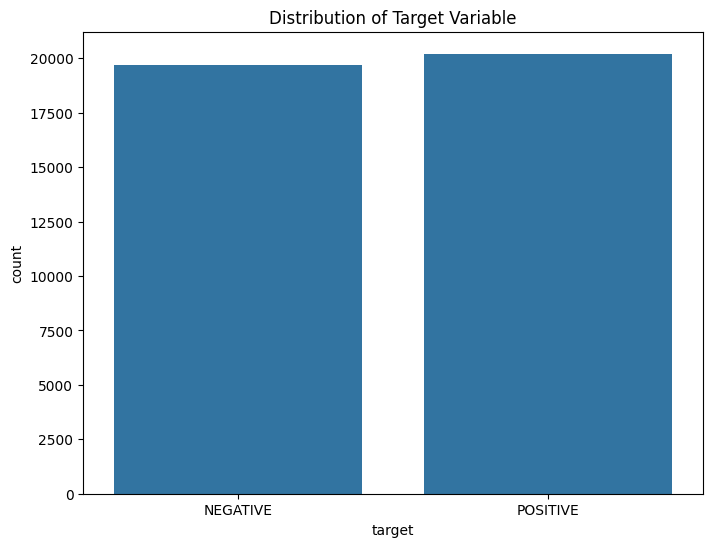

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='target')
plt.title('Distribution of Target Variable')
plt.show()

In [ ]:
df_train, df_val= train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)

## Training Fasttext and Word2vec

https://www.analyticsvidhya.com/blog/2023/01/introduction-to-fasttext-embeddings-and-its-implication/

In [ ]:
%%time
CURRENT_DIRECTORY = os.getcwd()
MODEL_PATH = os.path.join(CURRENT_DIRECTORY, "fasttext_model.bin")
TRAINING_DATA_PATH = os.path.join(CURRENT_DIRECTORY, "fasttext_train.txt")

if os.path.isfile(MODEL_PATH):
    fasttext_model = fasttext.load_model(MODEL_PATH)
else:
    sentences = [row.split() for row in df_train['text']]
    with open(TRAINING_DATA_PATH, "w") as f:
        for sentence in sentences:
            f.write(" ".join(sentence) + "\n")
    fasttext_model = fasttext.train_unsupervised(TRAINING_DATA_PATH, model='skipgram')
    fasttext_model.save_model(MODEL_PATH)


CPU times: total: 328 ms
Wall time: 773 ms


In [ ]:
# %%time
# MODEL_PATH = os.path.join(CURRENT_DIRECTORY, "word2vec_model.model")

# if os.path.isfile(MODEL_PATH):
#     w2v_model = Word2Vec.load(MODEL_PATH)
# else:
#     sentences = [row.split() for row in df_train['text']]
#     w2v_model = Word2Vec(sentences, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=NUM_CORE)
#     w2v_model.build_vocab(sentences)
#     w2v_model.train(sentences, total_examples=len(documents), epochs=W2V_EPOCH)
#     w2v_model.save(MODEL_PATH)

### Tokenization:

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_val = pad_sequences(tokenizer.texts_to_sequences(df_val.text), maxlen=SEQUENCE_LENGTH)
# x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

### Embedding Layer:

In [ ]:
%%time
EMBEDDING_DIM = fasttext_model.get_dimension()
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = fasttext_model.get_word_vector(word)

CPU times: total: 219 ms
Wall time: 399 ms


In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist()).reshape(-1,1)
y_val = encoder.transform(df_val.target.tolist()).reshape(-1,1)
# y_test = encoder.transform(df_test.target.tolist()).reshape(-1,1)

## Preparation for PyTorch Model:

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 3
LEARNING_RATE = 0.001

train_dataset = helper_model.TextDataset(x_train, y_train)
val_dataset = helper_model.TextDataset(x_val, y_val)
# test_dataset = helper_model.TextDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
directory_path = 'model'
helper_model.clean_directory(directory_path)

Deleted: model\rnn_bs128_epoch1.pt
Deleted: model\rnn_bs128_epoch2.pt
Deleted: model\rnn_bs128_epoch3.pt


In [ ]:
helper_model.train(train_loader, val_loader, embedding_matrix, BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, save_path="model/")

Epoch 1/3:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/3: 100%|██████████| 250/250 [02:56<00:00,  1.41it/s]


Epoch 1, Loss: 0.5534496970176697, Accuracy: 0.7461


Epoch 2/3: 100%|██████████| 250/250 [02:19<00:00,  1.80it/s]


Epoch 2, Loss: 0.5033564504384994, Accuracy: 0.7494


Epoch 3/3: 100%|██████████| 250/250 [05:05<00:00,  1.22s/it]


Epoch 3, Loss: 0.49503879046440125, Accuracy: 0.7510


In [ ]:
model = helper_model.SentimentClassifier(embedding_matrix) 
model_path = 'model\\rnn_bs128_epoch3.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

## Evaluate

Evaluate on the validation set

Accuracy: 0.7510
F1-Score: 0.7577
ROC-AUC: 0.8336


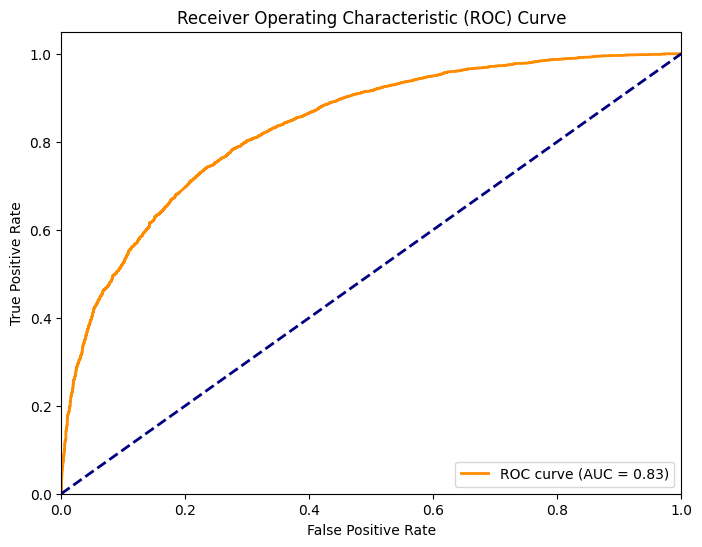

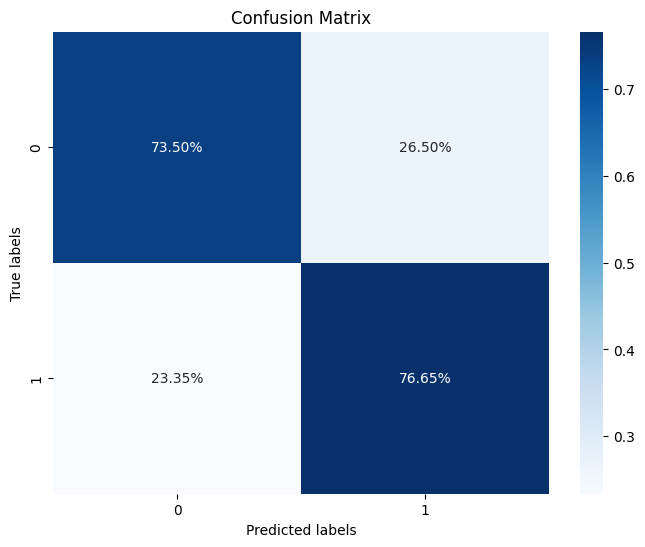

              precision    recall  f1-score   support

    NEGATIVE       0.75      0.74      0.74      3929
    POSITIVE       0.75      0.77      0.76      4052

    accuracy                           0.75      7981
   macro avg       0.75      0.75      0.75      7981
weighted avg       0.75      0.75      0.75      7981



In [ ]:
mislabeled_examples = helper_model.evaluate_model(model, val_loader, y_val, embedding_matrix, df_val["text"], threshold=0.5)

## Test

Evaluate on the testing set

In [ ]:
dataset_path = os.path.join("", "data", dataset_filename["1"][0])
df1 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["1"][1], skiprows=1)
df1.rename(columns={df1.columns[0]: 'text'}, inplace=True)
# decode_map = {-1: "NEGATIVE", 1: "POSITIVE"}
# df1.target = df1.target.apply(lambda x: decode_map[int(x)])
df1.text = df1.text.apply(lambda x: preprocess(x))


x_test = pad_sequences(tokenizer.texts_to_sequences(df1['text']), maxlen=SEQUENCE_LENGTH)
test_dataset = helper_model.TextDataset(x_test, np.zeros_like(x_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
df1["target"] = df1["target"].map({-1: "NEGATIVE", 1: "POSITIVE"})
y_test = encoder.transform(df1['target'].tolist()).reshape(-1, 1)

Accuracy: 0.5597
F1-Score: 0.6242
ROC-AUC: 0.5803


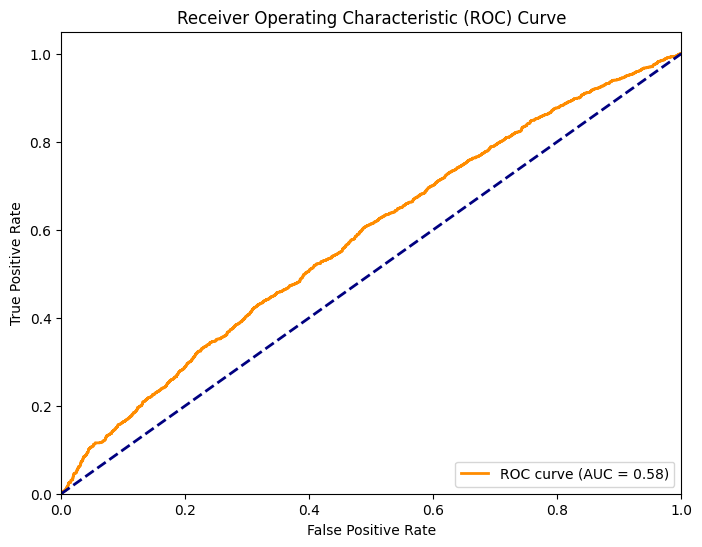

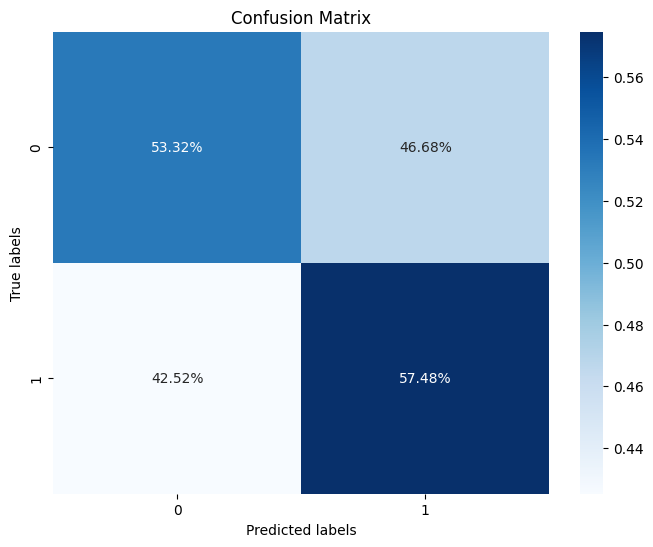

              precision    recall  f1-score   support

    NEGATIVE       0.42      0.53      0.47      2106
    POSITIVE       0.68      0.57      0.62      3685

    accuracy                           0.56      5791
   macro avg       0.55      0.55      0.55      5791
weighted avg       0.59      0.56      0.57      5791



In [ ]:
res_stock = helper_model.evaluate_model(model, test_loader, y_test, embedding_matrix, df1["text"], threshold=0.5)

In [ ]:
mislabels = res_stock
short_texts, texts_with_not, other_errors = helper_model.categorize_errors(mislabels)
helper_model.quantify_errors(short_texts, texts_with_not, other_errors)
helper_model.deep_dive(short_texts, texts_with_not)

Number of short texts: 326
Number of texts with 'not': 61
Number of other errors: 2163

Examples of short texts:
mnta 12 00
red ready break
bac 11 97 trade
sk gave
p long 9 55

Examples of texts with 'not':
nvda love see momo next week like previous histogram bars noted
user saying zagg another 23
fio nothing air stock 17 70 17 80
fio bouncing morning 25 short interest still nothing air till 17 90s
anyone noticed hge volume today thing pushes 6 today might runner next week


In [ ]:
helper_model.print_mislabeled_examples(res_stock)

Example 1:
Original Text: mnta 12 00
Predicted Label: 0
True Label: 1


Example 2:
Original Text: monday relative weakness nyx win tie tap ice int bmc aon c chk biib
Predicted Label: 1
True Label: 0


Example 3:
Original Text: aap watch tomorrow ong entry
Predicted Label: 0
True Label: 1


Example 4:
Original Text: assuming fcx opens tomorrow 34 25 trigger buy still much like setup
Predicted Label: 0
True Label: 1


Example 5:
Original Text: user gameplan shot today liked trend break may c h break oc weekly trend break back july 2011
Predicted Label: 0
True Label: 1


Example 6:
Original Text: fcx gapping well ideal entry looking pull least 35 open entry
Predicted Label: 0
True Label: 1


Example 7:
Original Text: swy 30 float short breaking ouch
Predicted Label: 0
True Label: 1


Example 8:
Original Text: biof wants 4 90 comin
Predicted Label: 0
True Label: 1


Example 9:
Original Text: vs inverted head shoulder play well able catch entry eyes
Predicted Label: 0
True Label: 1


Exampl